# 3. Pre-Processing <a id="data_wrangling"></a>

<a id="contents"></a>
# Table of Contents  
3.1. [Introduction](#introduction) <br>
3.2. [Imports](#imports)  <br>
3.3. [Data Processing](#process)<br>
3.4. [Data Splitting](#split)<br>
3.5. [Save Updated Data](#save)<br>
3.6. [Model Definition and Training]<br>
3.7. [Model Evaluation]<br>
3.8. [Save the Trained Model]

## 3.1 Introduction<a id="introduction"></a>

The goal of this notebook is to create a cleaned development dataset to be used to complete the modeling step of my project.

## 3.2 Imports<a id="imports"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import time

# Load the dataset
df = pd.read_csv('/Users/heatheradler/Documents/GitHub/Springboard/Springboard_Projects/Capstone 3/df_eda.csv')
print("Dataset loaded.")

# Print dataset columns to verify
print(df.columns)

Dataset loaded.
Index(['city', 'street_address', 'state', 'zipcode', 'house_type', 'price',
       'bathrooms', 'bedrooms', 'school_rating', 'yearBuilt', 'latitude',
       'longitude', 'sqft', 'heating', 'cooling', 'parking', 'basement',
       'tax_assessed_value', 'tax_amount', 'stories', 'lot_size_sqft',
       'borough', 'bathrooms_binned'],
      dtype='object')


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58860 entries, 0 to 58859
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                58860 non-null  object 
 1   street_address      58860 non-null  object 
 2   state               58860 non-null  object 
 3   zipcode             58860 non-null  float64
 4   house_type          58860 non-null  object 
 5   price               58860 non-null  float64
 6   bathrooms           58860 non-null  float64
 7   bedrooms            58860 non-null  float64
 8   school_rating       58860 non-null  float64
 9   yearBuilt           58860 non-null  float64
 10  latitude            58860 non-null  float64
 11  longitude           58860 non-null  float64
 12  sqft                58860 non-null  float64
 13  heating             58860 non-null  float64
 14  cooling             58860 non-null  float64
 15  parking             58860 non-null  float64
 16  base

## 3.3 Data Processing

In [3]:
# Define target variable and features
target = 'price'
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if target in numeric_features:
    numeric_features.remove(target)
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Apply log transformation to the target variable
df[target] = np.log1p(df[target])

# Define preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [4]:
df = df.drop(['street_address','parking', 'city' ], axis=1)

In [5]:
# Replace less frequent categories with 'Other'
counts = df['house_type'].value_counts()
mask = df['house_type'].isin(counts[counts < 130].index)
df.loc[mask, 'house_type'] = 'Other'

# Convert house_type to categorical
df['house_type'] = pd.Categorical(df['house_type'])

In [6]:
df.house_type = pd.Categorical(df.house_type)
df.house_type = df.house_type.cat.codes

In [7]:
df.borough = pd.Categorical(df.borough)
df.borough = df.borough.cat.codes

In [8]:
df.zipcode = pd.Categorical(df.zipcode)
df.zipcode = df.zipcode.cat.codes

/var/folders/9q/j_dp7nx93lbc_t5zbbshxpch0000gn/T/ipykernel_2209/4108956755.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax)


array([[<Axes: title={'center': 'zipcode'}>,
        <Axes: title={'center': 'house_type'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'bathrooms'}>],
       [<Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'school_rating'}>,
        <Axes: title={'center': 'yearBuilt'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'sqft'}>,
        <Axes: title={'center': 'heating'}>,
        <Axes: title={'center': 'cooling'}>],
       [<Axes: title={'center': 'basement'}>,
        <Axes: title={'center': 'tax_assessed_value'}>,
        <Axes: title={'center': 'tax_amount'}>,
        <Axes: title={'center': 'stories'}>],
       [<Axes: title={'center': 'lot_size_sqft'}>,
        <Axes: title={'center': 'borough'}>,
        <Axes: title={'center': 'bathrooms_binned'}>, <Axes: >]],
      dtype=object)

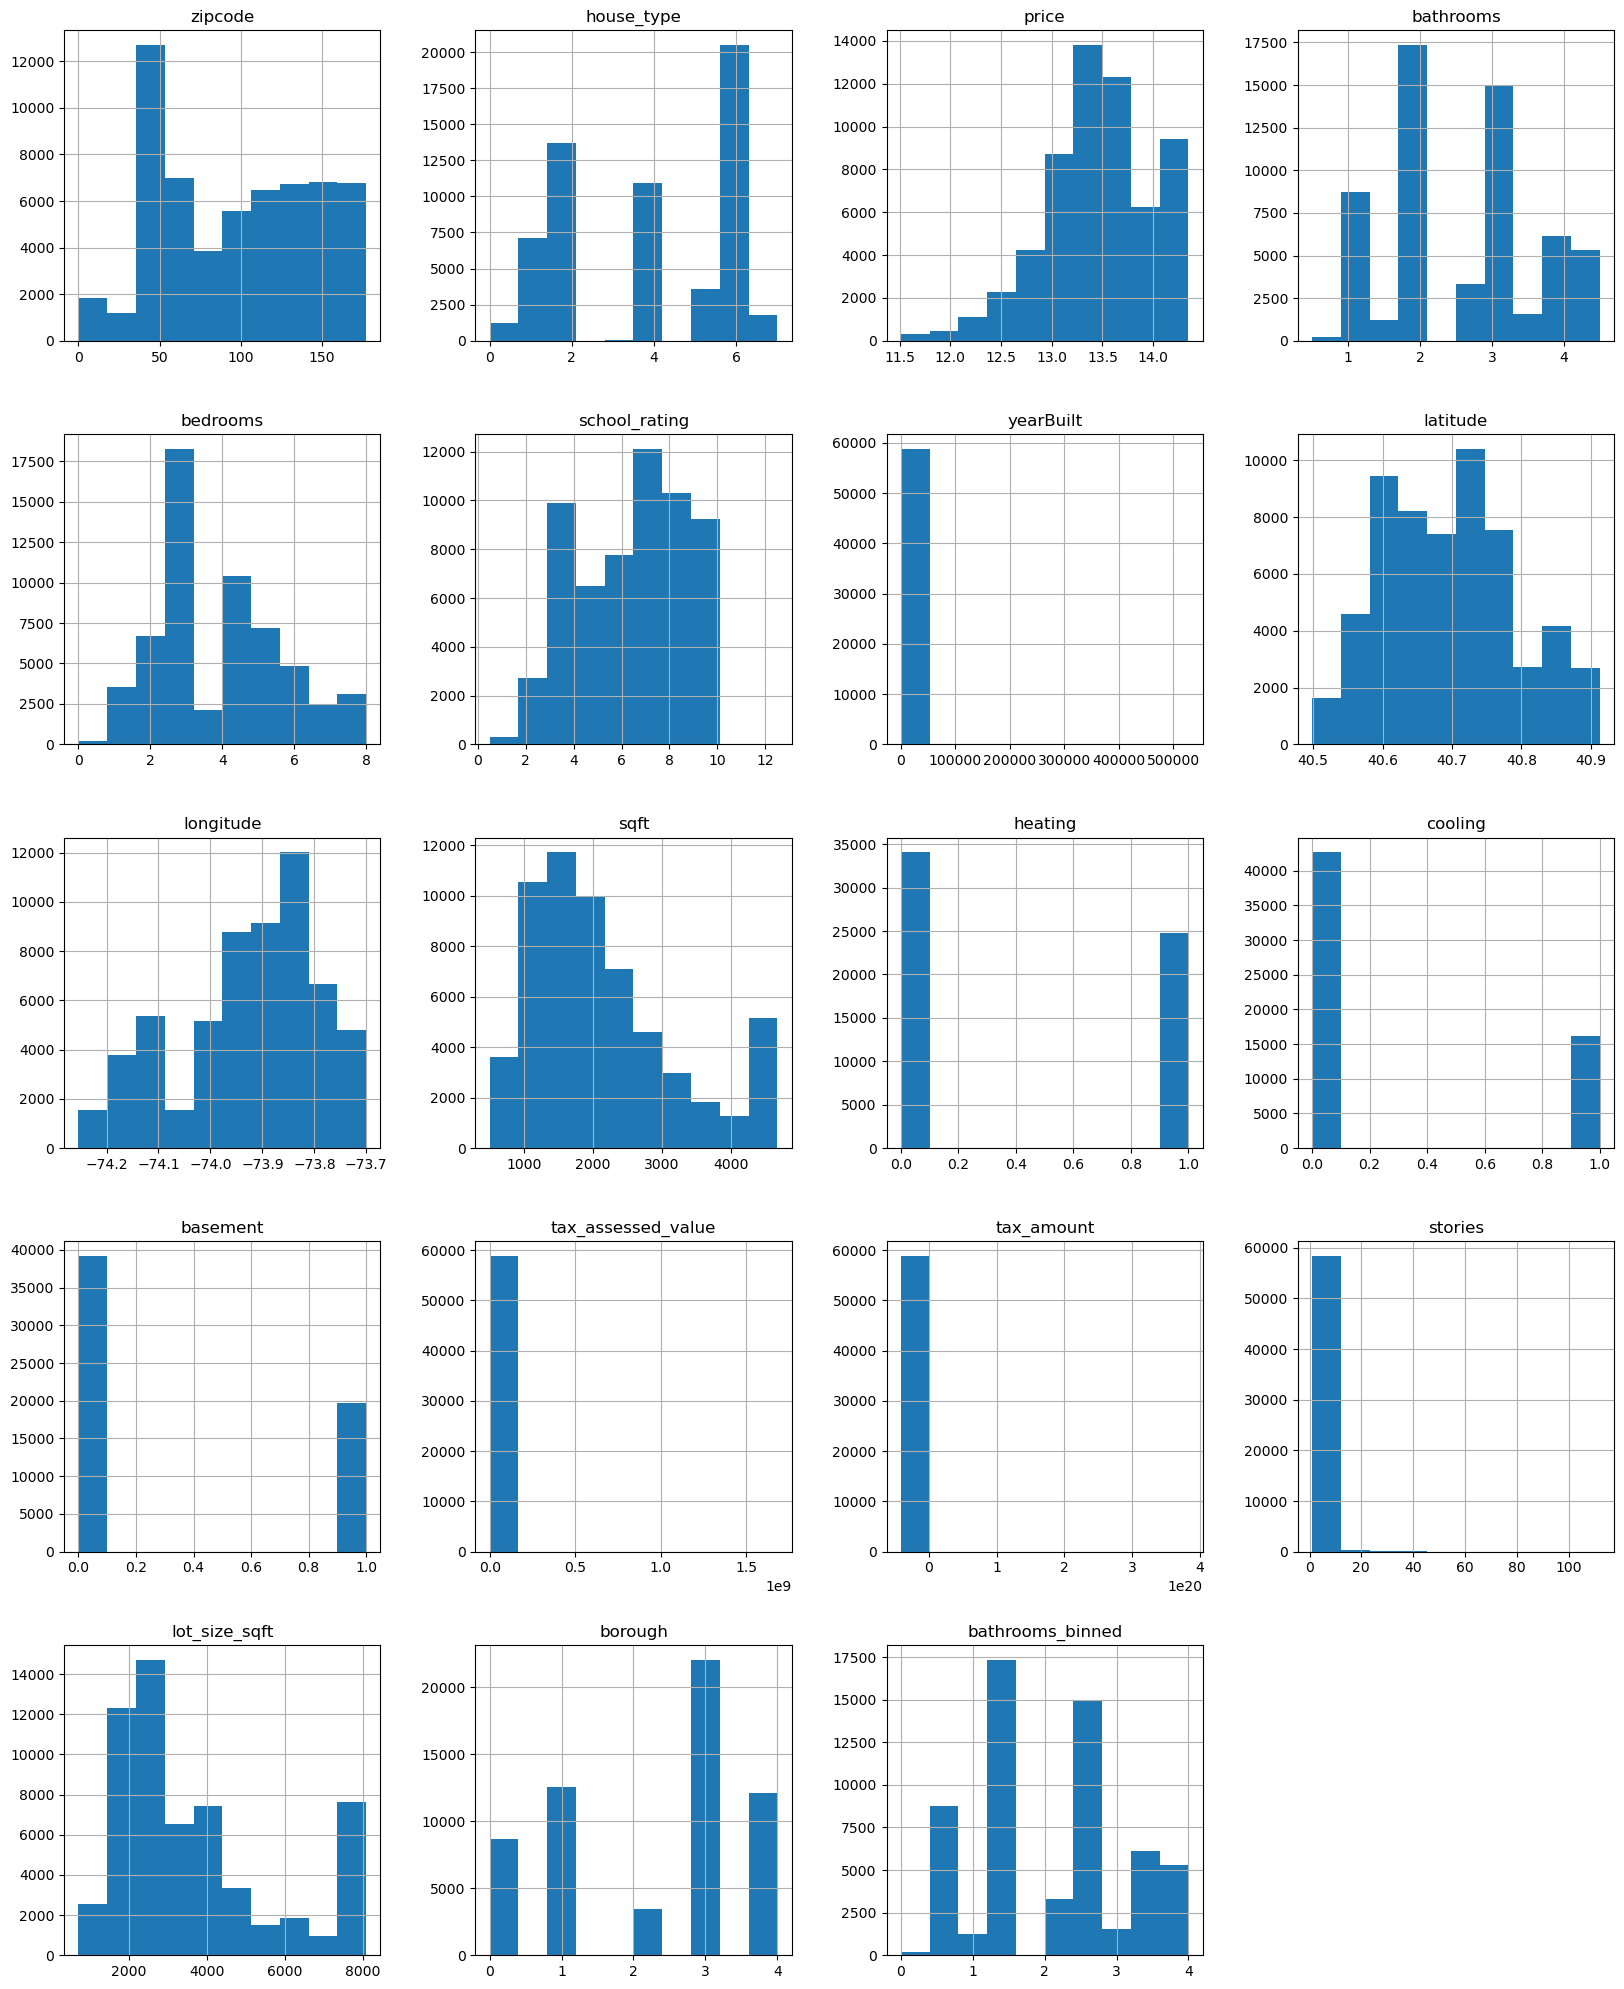

In [9]:
# Let's check the distribution of our features to better understand a better type of imputation
fig = plt.figure(figsize = (20,25))
ax = fig.gca()
df.hist(ax = ax)

## 3.4 Data Splitting

In [10]:
# Assuming 'price' is the target variable
X = df.drop(target, axis=1)
y = df[target]

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Scale numerical features using RobustScaler
scaler = RobustScaler()
X = scaler.fit_transform(X)
         
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3.5 Save Updated Data

In [11]:
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (47088, 19)
Test data shape: (11772, 19)


In [12]:
# Save preprocessed data
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train.to_numpy())
np.save('y_test.npy', y_test.to_numpy())

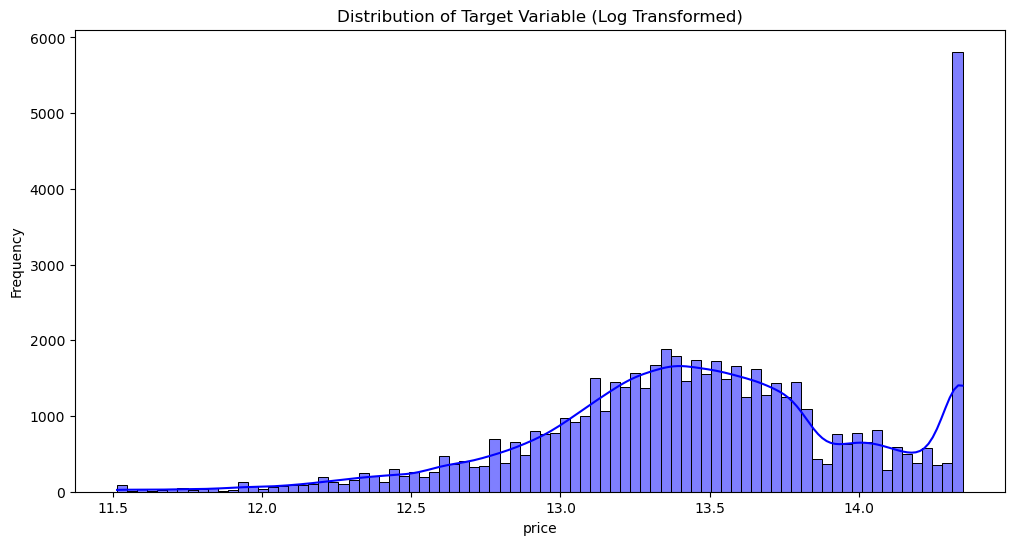

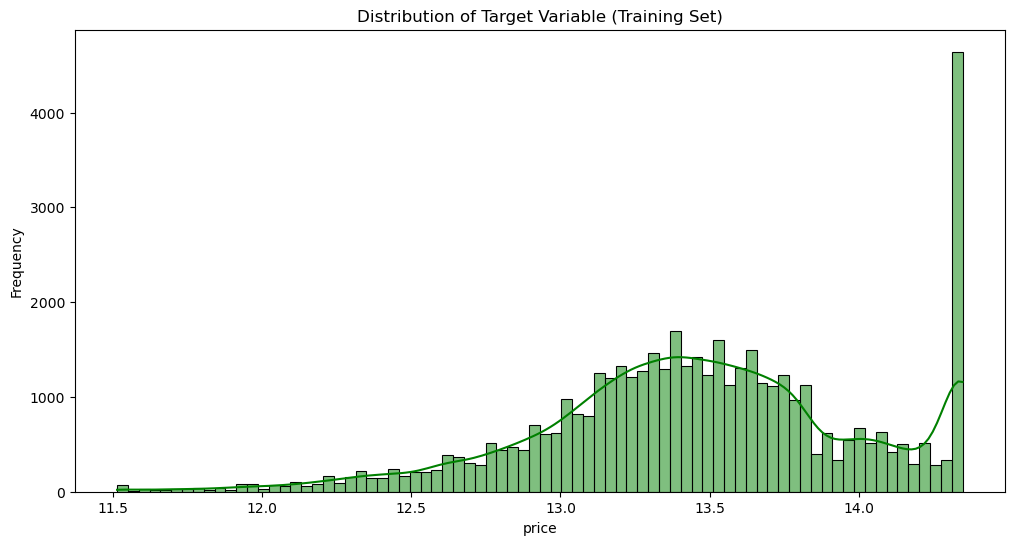

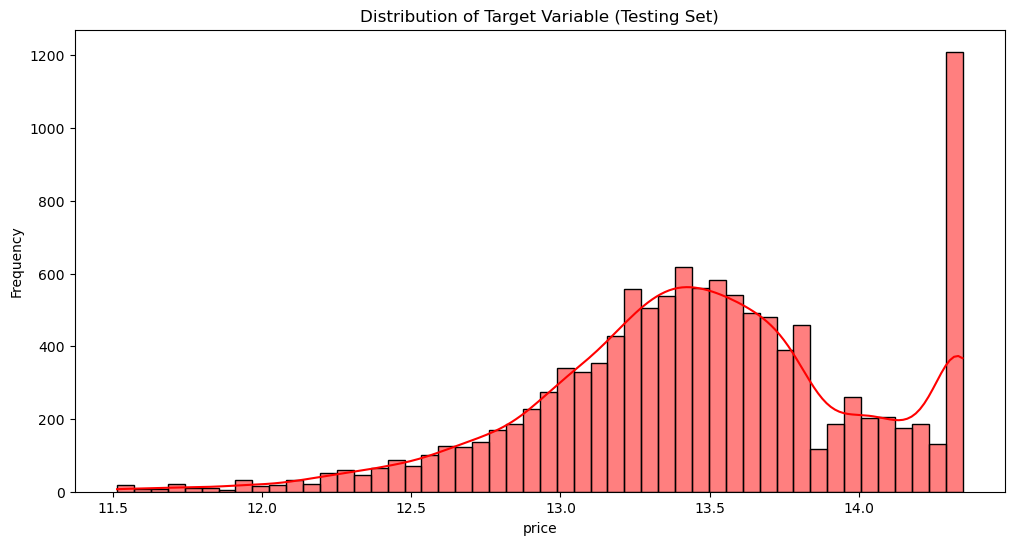

In [13]:
# Visualize the distribution of the target variable
plt.figure(figsize=(12, 6))
sns.histplot(df[target], kde=True, color='blue')
plt.title('Distribution of Target Variable (Log Transformed)')
plt.xlabel('price')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution in the training set
plt.figure(figsize=(12, 6))
sns.histplot(y_train, kde=True, color='green')
plt.title('Distribution of Target Variable (Training Set)')
plt.xlabel('price')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution in the testing set
plt.figure(figsize=(12, 6))
sns.histplot(y_test, kde=True, color='red')
plt.title('Distribution of Target Variable (Testing Set)')
plt.xlabel('price')
plt.ylabel('Frequency')
plt.show()

## 3.6 Model Definition and Training

In [14]:
# Define models and parameter grids
models = {
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
}

param_grids = {
    'GradientBoosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3]
    },
    'XGBRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    },
    'RandomForestRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None]
    }
}

In [15]:
# Function to train and evaluate models
def train_and_save_model(X_train, y_train, X_test, y_test, models, param_grids):
    best_model = None
    best_score = float('inf')
    best_model_name = None
    
    for model_name, model in models.items():
        search = RandomizedSearchCV(model, param_grids[model_name], n_iter=3, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
        
        # For XGBRegressor, include early stopping
        if model_name == 'XGBRegressor':
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
        else:
            search.fit(X_train, y_train)
            model = search.best_estimator_
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
        
        if rmse < best_score:
            best_score = rmse
            best_model = model
            best_model_name = model_name
        
        if model_name != 'XGBRegressor':
            print(f"{model_name} - Best Parameters: {search.best_params_} - RMSE: {rmse}")
        else:
            print(f"{model_name} - RMSE: {rmse}")
    
    return best_model, best_model_name, best_score

## 3.7 Model Evaluation

In [16]:
best_model, best_model_name, best_score = train_and_save_model(X_train, y_train, X_test, y_test, models, param_grids)
print(f"Best model is {best_model_name} with RMSE: {best_score}")

GradientBoosting - Best Parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1} - RMSE: 0.30246505897252285


/Users/heatheradler/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor - RMSE: 0.2870797035074488
RandomForestRegressor - Best Parameters: {'n_estimators': 300, 'max_depth': 20} - RMSE: 0.29053326000961116
Best model is XGBRegressor with RMSE: 0.2870797035074488


MAE (Train): 0.15728964888937158, MAE (Test): 0.17729633909625195
MSE (Train): 0.06331682870168007, MSE (Test): 0.08241475616592471
RMSE (Train): 0.2516283543277269, RMSE (Test): 0.2870797035074488
R2 (Train): 0.7838999184101512, R2 (Test): 0.7169744072515661


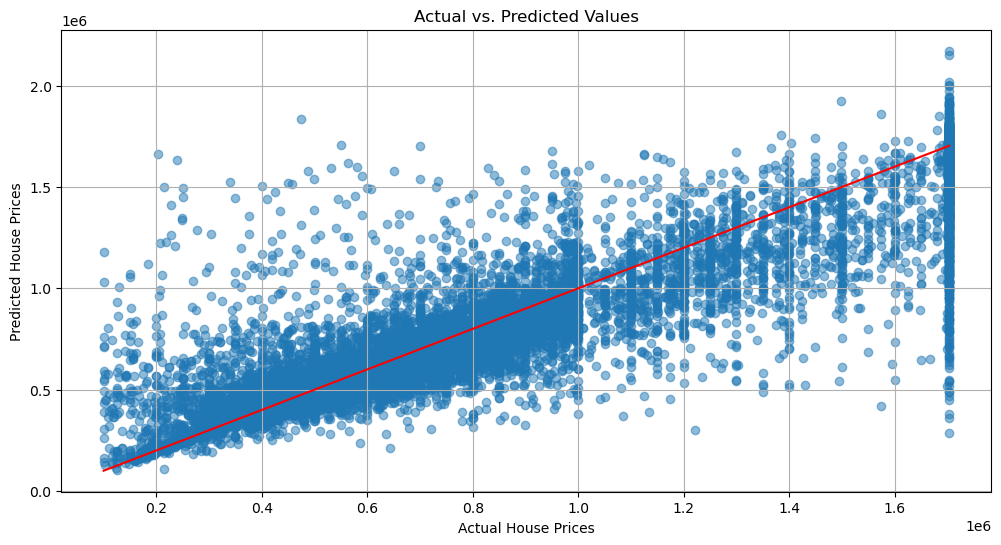

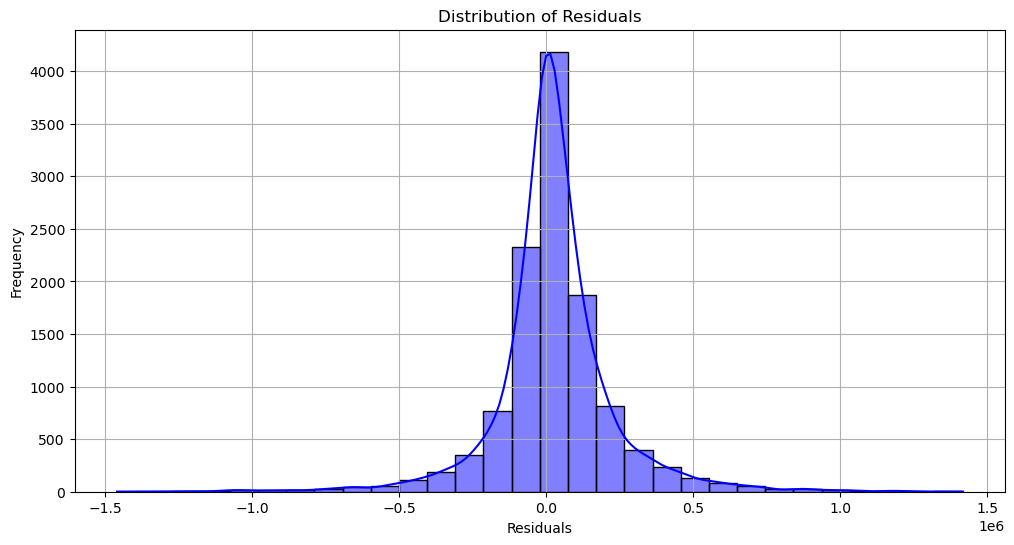

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model_with_visualization(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    r2_train = r2_score(y_train, y_train_pred)

    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"MAE (Train): {mae_train}, MAE (Test): {mae_test}")
    print(f"MSE (Train): {mse_train}, MSE (Test): {mse_test}")
    print(f"RMSE (Train): {rmse_train}, RMSE (Test): {rmse_test}")
    print(f"R2 (Train): {r2_train}, R2 (Test): {r2_test}")

    # Transforming log values back to original scale
    y_test_actual = np.expm1(y_test)
    y_test_pred_actual = np.expm1(y_test_pred)

    # Plotting the actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test_actual, y_test_pred_actual, alpha=0.5)
    plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red')
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Actual House Prices')
    plt.ylabel('Predicted House Prices')
    plt.grid(True)
    plt.show()

    # Plotting residuals
    residuals = y_test_actual - y_test_pred_actual
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True, bins=30, color='blue')
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example of using the function
# model = your_trained_model
evaluate_model_with_visualization(best_model, X_train, y_train, X_test, y_test)

In [18]:
df.head()

,state,zipcode,house_type,price,bathrooms,bedrooms,school_rating,yearBuilt,latitude,longitude,sqft,heating,cooling,basement,tax_assessed_value,tax_amount,stories,lot_size_sqft,borough,bathrooms_binned
0,NY,64,4,13.592367,2.0,5.0,4.0,1920.0,40.877743,-73.910866,1889.000000,1.0,0.0,1.0,711000.0,5096.000000,1.0,2845.695988,0,1.5
1,NY,72,6,14.348186,4.5,8.0,10.0,1940.0,40.892689,-73.910667,4675.000000,0.0,1.0,0.0,1937000.0,13941.000000,1.0,8081.496824,0,4.0
2,NY,64,6,14.217637,3.0,4.0,10.0,1920.0,40.883419,-73.918106,4233.000000,0.0,0.0,0.0,2341000.0,12253.000000,2.0,8081.496824,0,2.5
3,NY,64,6,14.348186,4.5,5.0,10.0,1950.0,40.885033,-73.917793,4675.000000,0.0,1.0,0.0,3011000.0,19472.000000,2.0,8081.496824,0,4.0
4,NY,64,6,14.348186,4.5,5.0,10.0,2020.0,40.881702,-73.914185,4079.814648,0.0,1.0,0.0,1790000.0,19016.384069,1.0,7392.428982,0,4.0


## 3.8 Save the Trained Model

In [19]:
joblib.dump(best_model, f'best_model_{best_model_name}.pkl')

['best_model_XGBRegressor.pkl']

Feature Importance Keys: dict_keys(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16'])


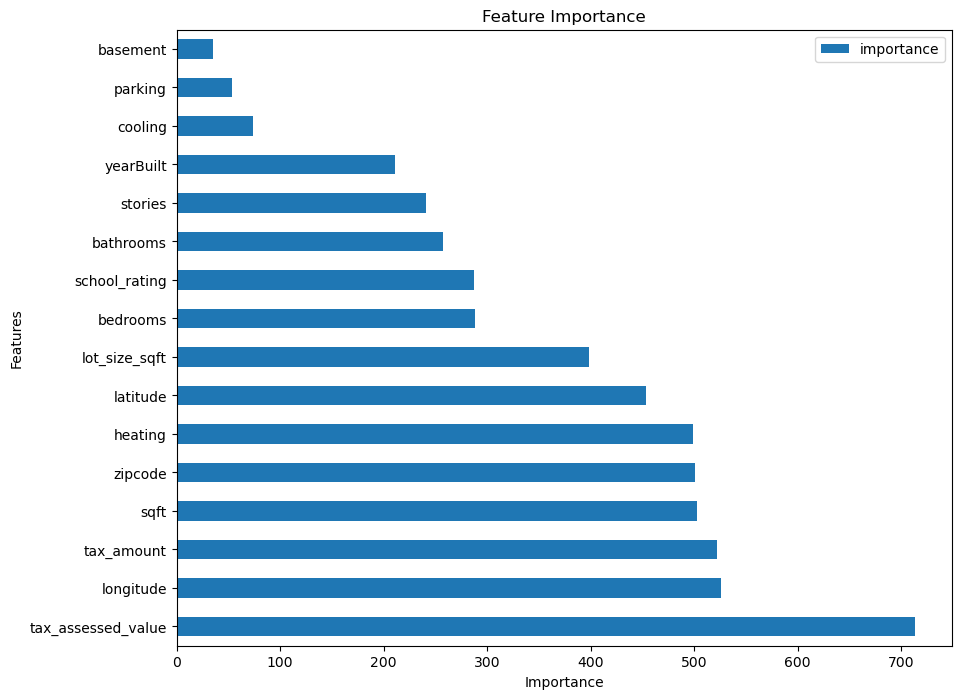

In [20]:
from xgboost import plot_importance

# Train the XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Get feature importance
booster = xgb_model.get_booster()
feature_importance = booster.get_score(importance_type='weight')

# Print feature importance keys to understand the indices
print("Feature Importance Keys:", feature_importance.keys())

# Ensure the feature names list matches the indices in the importance scores
# Add placeholders if actual feature names are not known
feature_names = [
    'zipcode', 'bathrooms', 'bedrooms', 'school_rating', 'yearBuilt', 
    'latitude', 'longitude', 'sqft', 'heating', 'cooling', 'parking', 
    'basement', 'tax_assessed_value', 'tax_amount', 'stories', 'lot_size_sqft', 'basement'
]

# Map feature indices to names
mapped_importances = {feature_names[int(k[1:])]: v for k, v in feature_importance.items()}

# Convert to a DataFrame for better visualization
importances_df = pd.DataFrame.from_dict(mapped_importances, orient='index', columns=['importance'])

# Plot feature importances
importances_df = importances_df.sort_values(by='importance', ascending=False)
importances_df.plot(kind='barh', figsize=(10, 8))
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()